<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part8/P8_Ch05_CH05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Super Resolution 학종이만한사진 확대하기
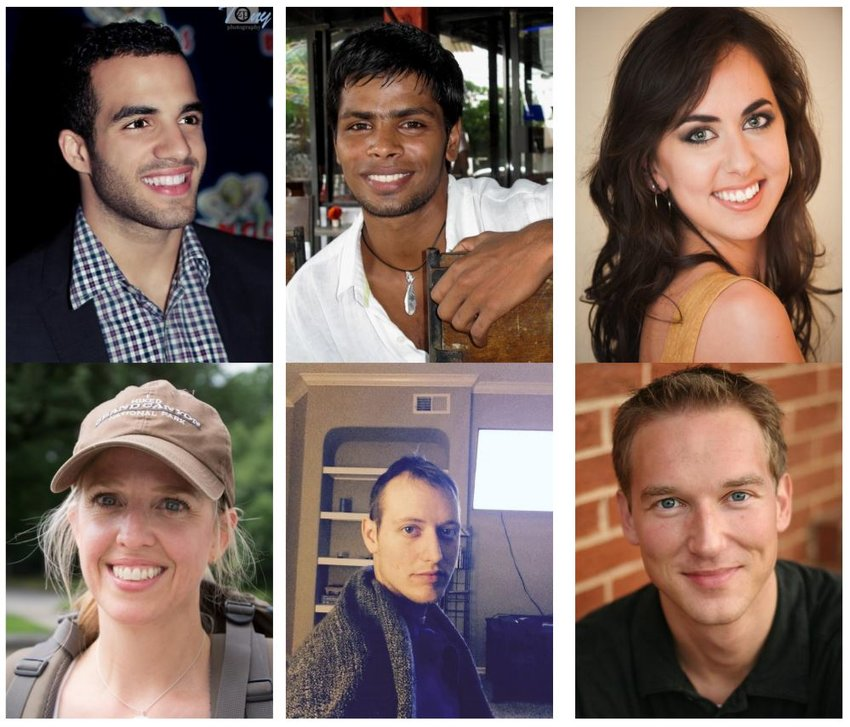

위의 이미지는 다음과 같은 것을 보여줍니다.  
- 800x600의 사람 portrait 이미지  
    - ?????.png  
- 사람 영역에 대한 흑백 portrait 이미지
    - ?????_matte.png
- pfcn_original
    - 원본 800x600 이미지들.
- pfcn_small
    - colab용 100x75 이미지들



- 데이터 출처:
 - [PFCN dataset](https://1drv.ms/u/s!ApwdOxIIFBH19Ts5EuFd9gVJrKTo)

 - [pfcn_small](https://drive.google.com/file/d/1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl/view?usp=sharing)


## 최종목표
- 큰사진 작게 줄이기
- 작게 줄인 PFCN데이터를 이용해 사람 영역 추출
- 이미지에 대한 오토인코더식 접근 방법

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image


import os
import imageio

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

# 1. EDA, 데이터 구축

In [3]:
!ls -al /content/drive/MyDrive/딥러닝_정주행/pfcn_original/testing/??001.png

-rw------- 1 root root 753417 Oct  7  2016 /content/drive/MyDrive/딥러닝_정주행/pfcn_original/testing/00001.png


In [4]:
import imageio
x = imageio.imread('/content/drive/MyDrive/딥러닝_정주행/pfcn_original/training/00001.png')

In [5]:
x.shape

(800, 600, 3)

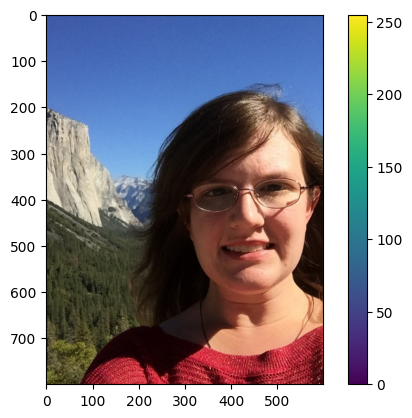

In [6]:
# pfcn original
plt.imshow(x)
plt.colorbar()
plt.show()

In [7]:
# pfcn original : (800, 600, 3) 너무 크기 떄문에 -> train_big : (200, 150, 3)으로 축소해서 사용 할것임

from skimage.transform import resize
x = resize(x, (200, 150, 3))

In [8]:
x.shape

(200, 150, 3)

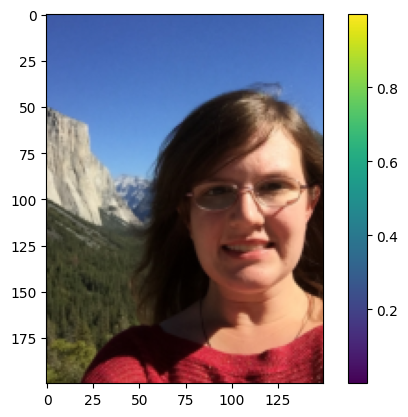

In [9]:
plt.imshow(x)
plt.colorbar()
plt.show()

- resize -> normalize 가 자동으로 처리됨


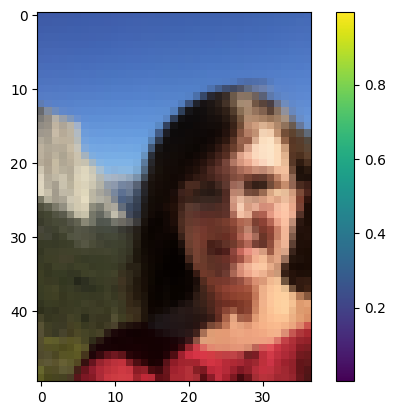

In [10]:
# train_small : (50, 37, 3)으로 축소해서 사용할것임

from skimage.transform import resize
x = resize(x, (50, 37, 3))
plt.imshow(x)
plt.colorbar()
plt.show()

In [54]:
# train_big : (200, 150, 3)으로 변경
# train_small data : (50, 37, 3)으로 변경
train_path = "/content/drive/MyDrive/딥러닝_정주행/pfcn_original/training"

# training 내 모든 .png 파일에 대해 이미지 크기 변경 후 배열에 추가(mattes파일 제외)
train_big_images = np.array([resize(imageio.imread(os.path.join(train_path, x)), (200, 150, 3)) for x in os.listdir(train_path) if x.endswith('.png')and 'matte' not in x])

# train_big_images의 shape 확인
print(train_big_images.shape)


(1700, 200, 150, 3)


In [55]:
train_small_images = np.array([resize(img, (50, 37, 3)) for img in train_big_images])

In [56]:
test_path = "/content/drive/MyDrive/딥러닝_정주행/pfcn_original/testing"

# testing 내 모든 .png 파일에 대해 이미지 크기 변경 후 배열에 추가(mattes파일 제외)
test_big_images = np.array([resize(imageio.imread(os.path.join(test_path, x)), (200, 150, 3)) for x in os.listdir(test_path) if x.endswith('.png')and 'matte' not in x])

# test_big_images의 shape 확인
print(test_big_images.shape)

(300, 200, 150, 3)


In [57]:
test_small_images = np.array([resize(img, (50, 37, 3)) for img in test_big_images])

In [58]:
train_big_images.dtype

dtype('float64')

In [59]:
output_path = "/content/drive/MyDrive/딥러닝_정주행/pfcn_original/resized"

# 디렉토리가 존재하지 않으면 생성
if not os.path.exists(output_path):
    os.makedirs(output_path)

# train_big_images 배열을 저장
np.savez(os.path.join(output_path, "train_big_images.npz"), train_big_images)
np.savez(os.path.join(output_path, "train_small_images.npz"), train_small_images)
np.savez(os.path.join(output_path, "test_big_images.npz"), test_big_images)
np.savez(os.path.join(output_path, "test_small_images.npz"), test_small_images)


In [2]:
output_path = "/content/drive/MyDrive/딥러닝_정주행/pfcn_original/resized"
train_big_images = np.load(os.path.join(output_path, "train_big_images.npz"))['arr_0']
train_small_images = np.load(os.path.join(output_path, "train_small_images.npz"))['arr_0']
test_big_images = np.load(os.path.join(output_path, "test_big_images.npz"))['arr_0']
test_small_images = np.load(os.path.join(output_path, "test_small_images.npz"))['arr_0']

In [60]:
train_big_images[train_big_images !=0][:10]

array([0.71951457, 0.71951457, 0.71951457, 0.71964908, 0.71964908,
       0.71964908, 0.72084384, 0.72084384, 0.72084384, 0.72169807])

In [61]:
train_small_images[train_small_images !=0][:10]

array([0.72483604, 0.72483604, 0.72483604, 0.72961713, 0.72961713,
       0.72961713, 0.73354324, 0.73354324, 0.73354324, 0.73724137])

In [62]:
train_big_images.dtype, train_small_images.dtype

(dtype('float64'), dtype('float64'))

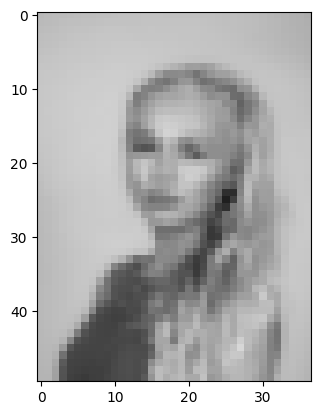

In [63]:
# small data
plt.imshow(train_small_images[0])

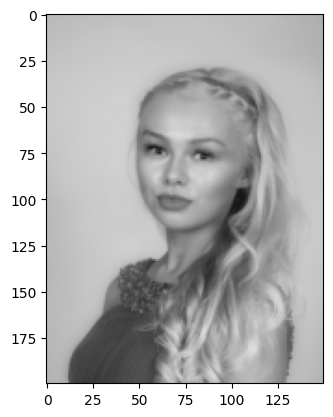

In [64]:
# big data
plt.imshow(train_big_images[0])

# 2. 전처리

In [65]:
# 데이터 범위 확인
print(train_big_images[train_big_images >1.0][:10])
print(train_big_images[train_big_images >0.9][:10])
print(train_big_images[train_big_images < 0.0][:10])

[]
[0.9051065  0.90914237 0.90071585 0.90130396 0.91375769 0.91713748
 0.92395084 0.92869773 0.93095833 0.92941199]
[]


In [66]:
train_big_images.max(), train_big_images.min()

(1.0, 0.0)

In [67]:
test_big_images.max(), test_big_images.min()

(1.0, 0.0)

# 3. 시각화

In [68]:
train_big_images[:5].shape

(5, 200, 150, 3)

In [69]:
# big : (200, 150*5, 3)로 shape로 변경

five_train_big = train_big_images[:5].transpose((1, 0, 2, 3)).reshape((200, -1, 3))
five_train_big.shape

(200, 750, 3)

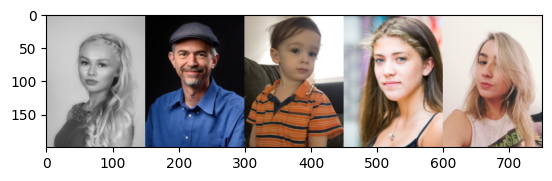

In [70]:
plt.imshow(five_train_big)

In [73]:
# small (50, 137*5, 3)로 shape로 변경

five_train_small = train_small_images[:5].transpose((1, 0, 2, 3)).reshape((50, -1, 3))
five_train_small.shape

(50, 185, 3)

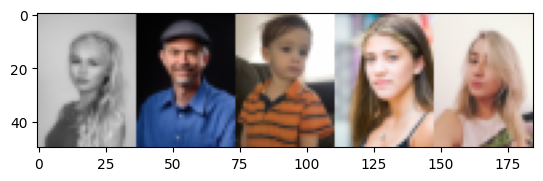

In [74]:
plt.imshow(five_train_small)

# 4. Modeling

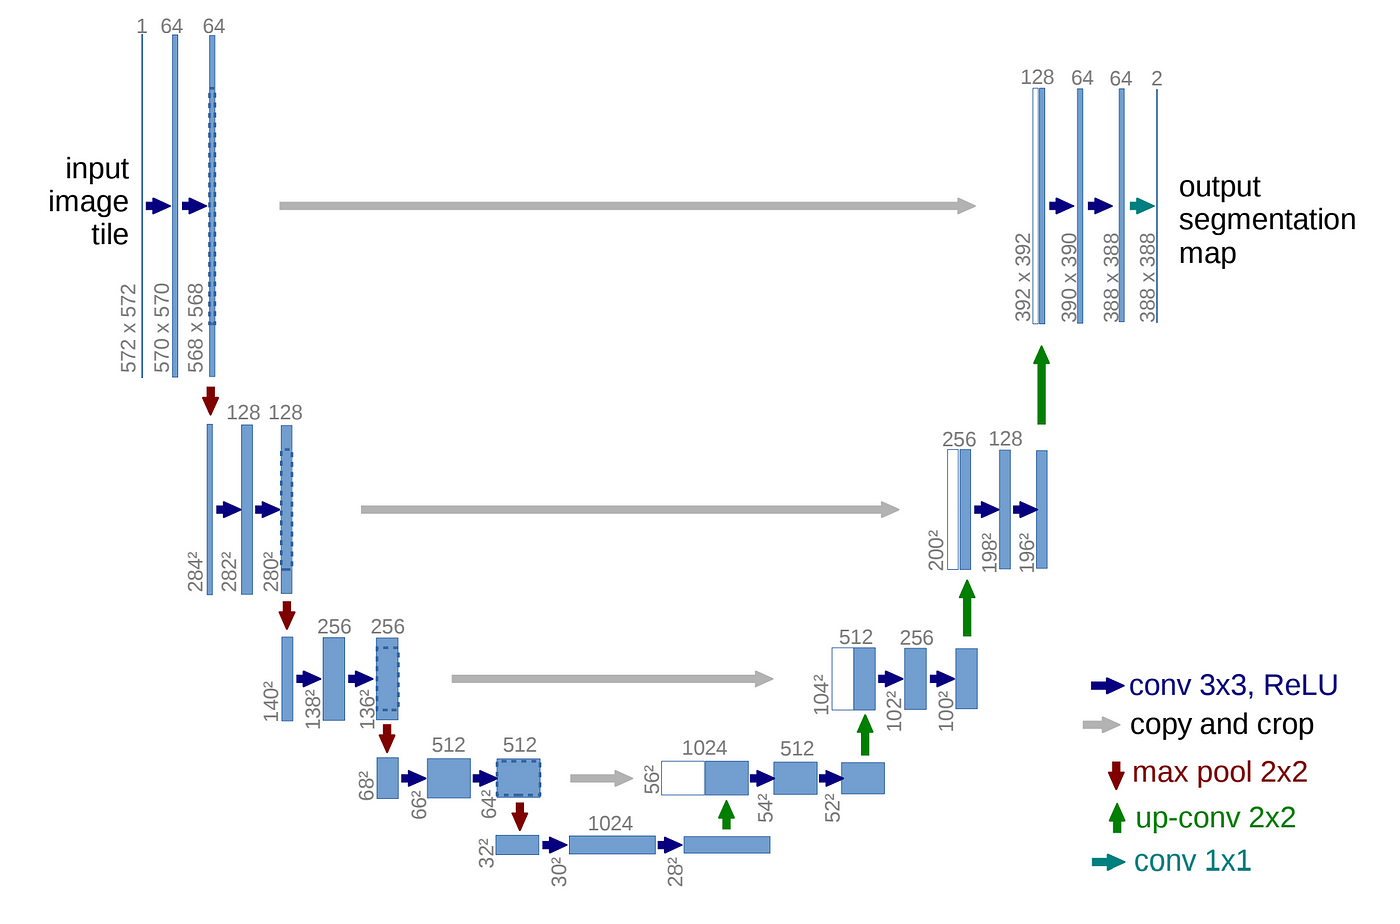

In [12]:
# input (50, 37, 3), output (200, 150, 3)를 처리할 수 있는 오토인코더 모델

from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.layers import MaxPool2D, BatchNormalization, Dropout, Activation, concatenate


def conv2d_block(x, channel):
    x = Conv2D(channel, (3,3), padding ='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(channel, (3,3), padding ='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet_resolution():
    inputs = Input((50, 37, 3))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, (2,2), strides = (2,2))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, (2,2), strides = (2,2), padding= 'valid', output_padding =(0,1))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, (2,2), strides = (2,2), padding= 'valid', output_padding =(1,0))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, (2,2), strides = (2,2), padding= 'valid', output_padding =(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    u10 = Conv2DTranspose(16, (2,2), strides = (2,2), padding= 'valid', output_padding =(0,1))(c9)
    u10 = MaxPool2D(2)(u10)
    u10 = Dropout(0.1)(u10)

    u11 = Conv2DTranspose(8, (2,2), strides = (2,2), padding= 'valid', output_padding =(0,1))(u10)

    u12 = Conv2DTranspose(4, (2,2), strides = (2,2), padding= 'same')(u11)


    outputs = Conv2D(3, (1,1), activation='sigmoid')(u12)

    return Model(inputs, outputs)


In [13]:
model1 = unet_resolution()
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50, 37, 3)]          0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 50, 37, 16)           448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 50, 37, 16)           64        ['conv2d_5[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 50, 37, 16)           0         ['batch_normalization[0]

In [14]:
model1.compile(loss ='mae', optimizer = 'adam', metrics = ['accuracy'])

In [15]:
hist1 = model1.fit(train_small_images, train_big_images, validation_data = (test_small_images, test_big_images), epochs = 30, verbose =1)

Epoch 1/30
54/54 [==============================] - 32s 86ms/step - loss: 0.2102 - accuracy: 0.4534 - val_loss: 0.1921 - val_accuracy: 0.4144
Epoch 2/30
54/54 [==============================] - 2s 46ms/step - loss: 0.1097 - accuracy: 0.5272 - val_loss: 0.1714 - val_accuracy: 0.6534
Epoch 3/30
54/54 [==============================] - 2s 45ms/step - loss: 0.0851 - accuracy: 0.6206 - val_loss: 0.1503 - val_accuracy: 0.6783
Epoch 4/30
54/54 [==============================] - 2s 40ms/step - loss: 0.0813 - accuracy: 0.6562 - val_loss: 0.1330 - val_accuracy: 0.6783
Epoch 5/30
54/54 [==============================] - 2s 40ms/step - loss: 0.0783 - accuracy: 0.6634 - val_loss: 0.1135 - val_accuracy: 0.6783
Epoch 6/30
54/54 [==============================] - 2s 40ms/step - loss: 0.0740 - accuracy: 0.6625 - val_loss: 0.0859 - val_accuracy: 0.6779
Epoch 7/30
54/54 [==============================] - 2s 40ms/step - loss: 0.0698 - accuracy: 0.6596 - val_loss: 0.0762 - val_accuracy: 0.6862
Epoch 8/30
5

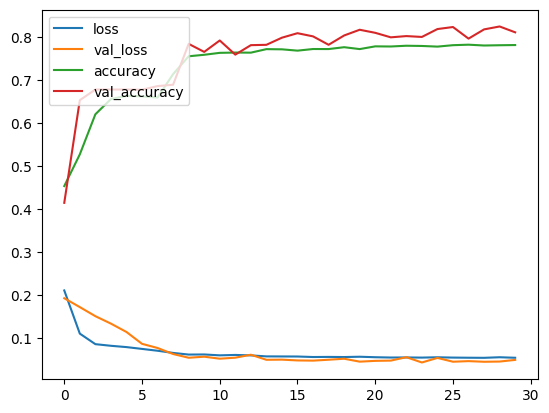

In [16]:
plt.plot(hist1.history['loss'], label ='loss')
plt.plot(hist1.history['val_loss'], label ='val_loss')
plt.plot(hist1.history['accuracy'], label ='accuracy')
plt.plot(hist1.history['val_accuracy'], label ='val_accuracy')
plt.legend(loc ='upper left')
plt.show()


# 5. 결과 확인

In [47]:
res = model1.predict(test_small_images[1:2])
res.shape, test_small_images[1:2].shape

1/1 [==============================] - 0s 468ms/step


((1, 200, 150, 3), (1, 50, 37, 3))

In [48]:
# test_small_images 확대

from skimage.transform import resize

exp = resize(test_small_images[1], (200, 150))
exp.shape

(200, 150, 3)

1/1 [==============================] - 0s 38ms/step


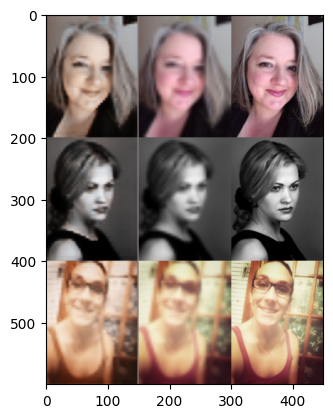

In [55]:
five2 = model1.predict(test_small_images[11:14])
exps = np.array([resize(img, (200, 150)) for img in test_small_images[11:14]])
total = np.concatenate([five2, exps, test_big_images[11:14]], axis =2).reshape((600, -1, 3))
plt.imshow(total)

- 모델결과/ 테스트용 저화질이미지/ 테스트용 고화질이미지
- 를 비교했을때 확실히 선명해진 모습을 알 수 있다.
- 원본사진과 색상이 약간 달라진 모습이 보인다

# 4.Modeling2 - srcnn

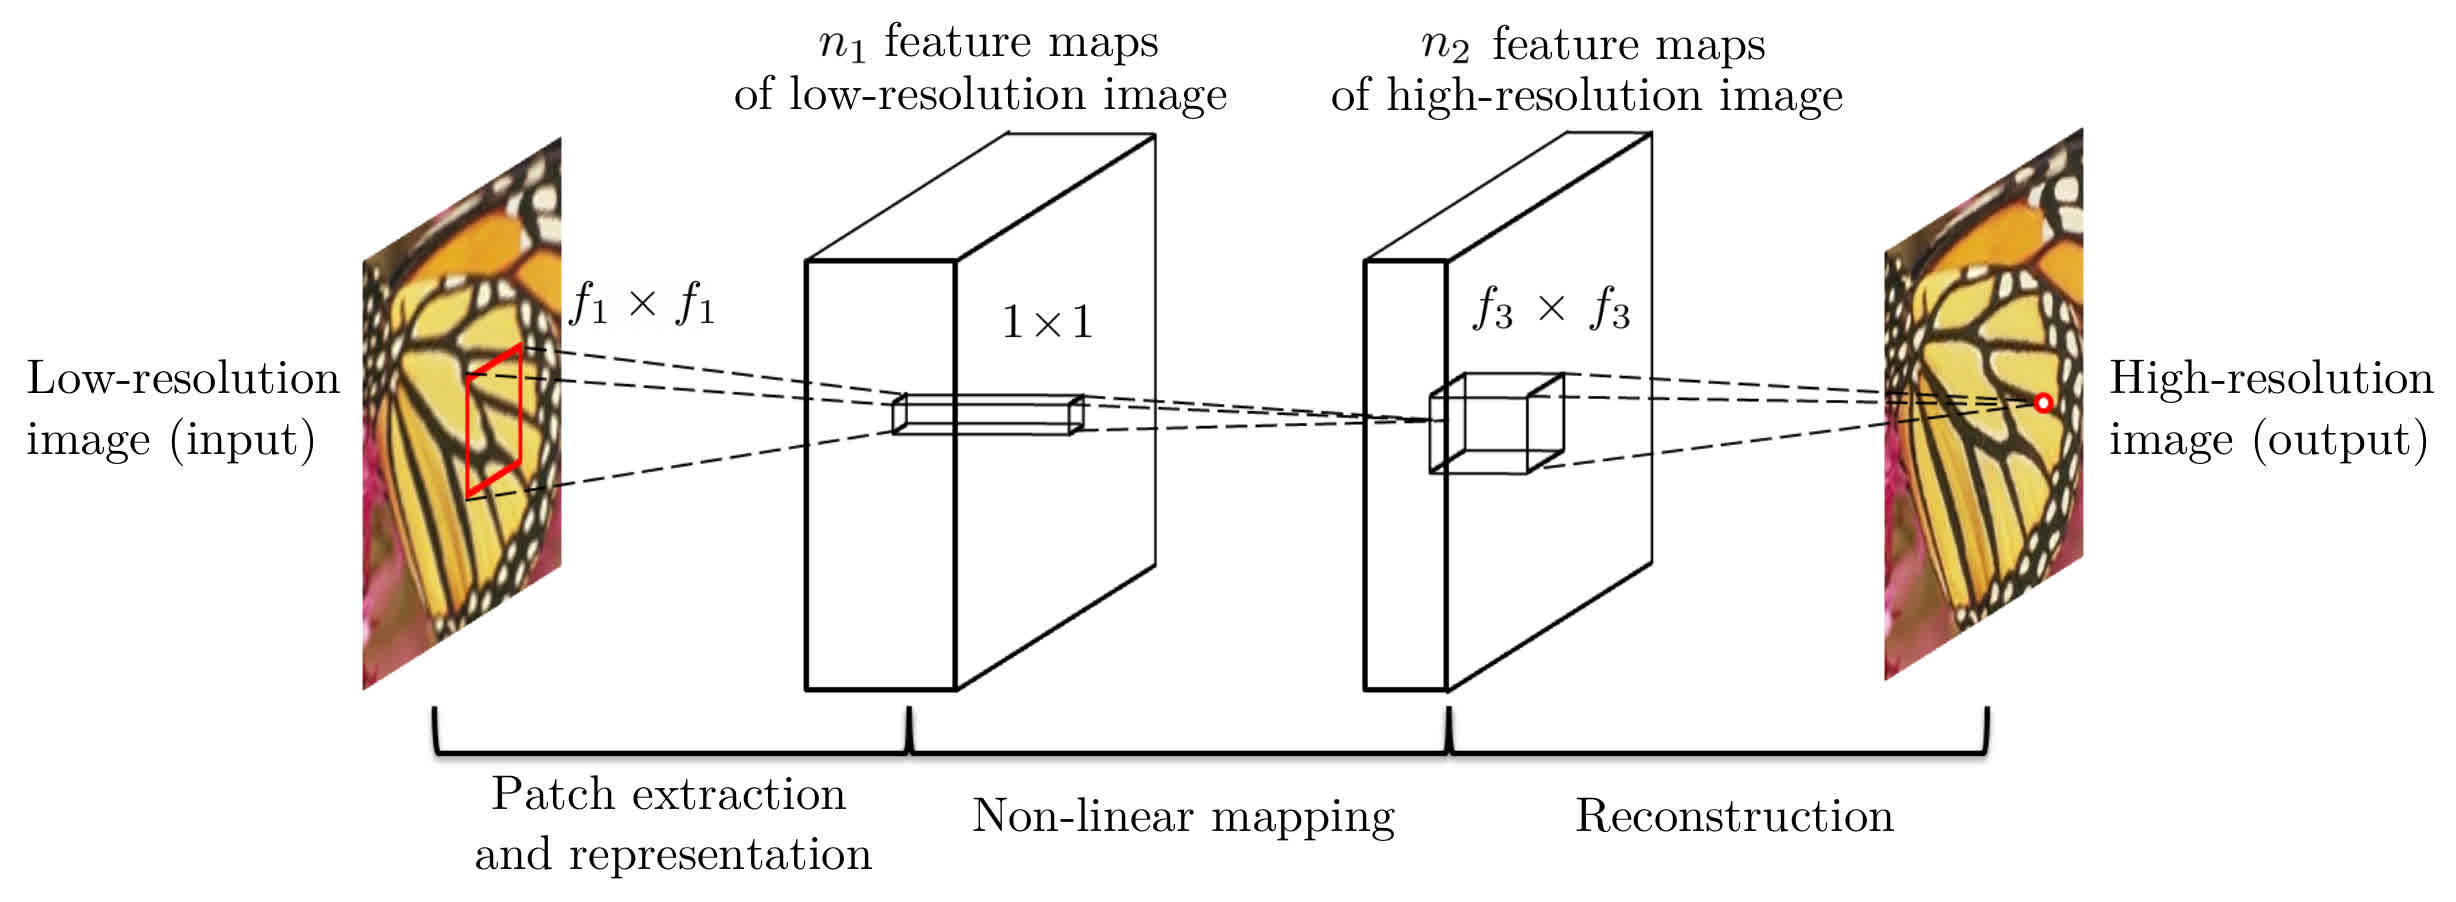

In [3]:
# small data -> big data 로 변환 데이터셋과 원본사진 비교
from skimage.transform import resize

test_lr_images = np.array([resize(img, (200, 150, 3)) for img in test_small_images])
train_lr_images = np.array([resize(img, (200, 150, 3)) for img in train_small_images])

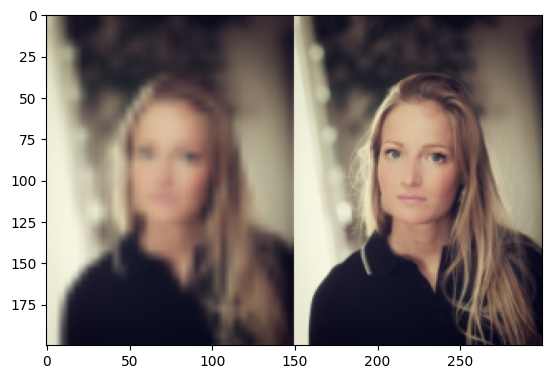

In [4]:
imgs =np.concatenate([test_lr_images[1], test_big_images[1]], axis=1)
plt.imshow(imgs)

In [5]:
from keras.layers import Average

from keras.layers import Input, Dense, Conv2D
from keras.models import Model

def srcnn():
    inputs = Input(shape=(200, 150, 3))
    x = Conv2D(64, (9, 9), activation='relu', padding='same')(inputs)
    x1 = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x3 = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = Average()([x1, x2, x3])

    outputs = Conv2D(3, (5, 5), activation='relu', padding='same')(x)
    model = Model(inputs, outputs)
    model.compile(loss = 'mae', optimizer = 'adam', metrics = ['accuracy'])

    return model

In [6]:
model2 = srcnn()
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 200, 150, 64)         15616     ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 200, 150, 32)         2080      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 200, 150, 32)         18464     ['conv2d[0][0]']              
                                                                                              

In [7]:
hist2 = model2.fit(train_lr_images, train_big_images, validation_data=(test_lr_images, test_big_images), epochs=30, verbose =1)

Epoch 1/30
54/54 [==============================] - 34s 229ms/step - loss: 0.1152 - accuracy: 0.6484 - val_loss: 0.0660 - val_accuracy: 0.7895
Epoch 2/30
54/54 [==============================] - 9s 163ms/step - loss: 0.0590 - accuracy: 0.7766 - val_loss: 0.0488 - val_accuracy: 0.8402
Epoch 3/30
54/54 [==============================] - 9s 165ms/step - loss: 0.0499 - accuracy: 0.7962 - val_loss: 0.0429 - val_accuracy: 0.8546
Epoch 4/30
54/54 [==============================] - 9s 162ms/step - loss: 0.0448 - accuracy: 0.8048 - val_loss: 0.0497 - val_accuracy: 0.8589
Epoch 5/30
54/54 [==============================] - 9s 170ms/step - loss: 0.0465 - accuracy: 0.8265 - val_loss: 0.0371 - val_accuracy: 0.8445
Epoch 6/30
54/54 [==============================] - 9s 168ms/step - loss: 0.0382 - accuracy: 0.8361 - val_loss: 0.0359 - val_accuracy: 0.8604
Epoch 7/30
54/54 [==============================] - 9s 173ms/step - loss: 0.0376 - accuracy: 0.8342 - val_loss: 0.0342 - val_accuracy: 0.7862
Epoch

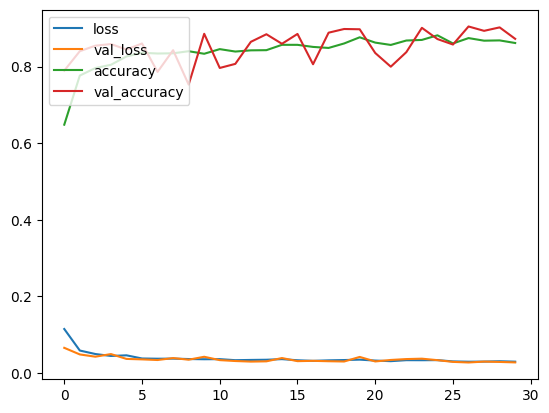

In [8]:
plt.plot(hist2.history['loss'], label ='loss')
plt.plot(hist2.history['val_loss'], label ='val_loss')
plt.plot(hist2.history['accuracy'], label ='accuracy')
plt.plot(hist2.history['val_accuracy'], label ='val_accuracy')
plt.legend(loc ='upper left')
plt.show()


1/1 [==============================] - 0s 64ms/step


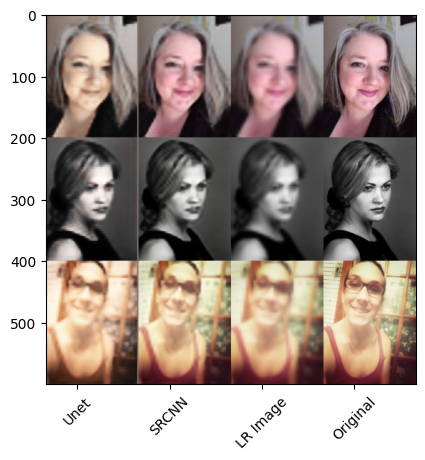

In [19]:
five2 = model1.predict(test_small_images[11:14])
five3 = model2.predict(test_lr_images[11:14])

total = np.concatenate([five2, five3, test_lr_images[11:14], test_big_images[11:14]], axis =2).reshape((600, -1, 3))

plt.xticks([50, 200, 350, 500], ['Unet', 'SRCNN', 'LR Image', 'Original'], rotation=45)
plt.imshow(total)

- 복잡한 구조로 설계된 Unet보다 간단한레이어로 설계된 srcnn모델이 시각적으로 봤을때 성능이 더 좋은것으로 보여진다.

In [11]:
model2.save('/content/drive/MyDrive/딥러닝_정주행/P8_Ch05.학종이만한사진을확대하기/model2.h5')